# **Local field potential analysis with open source tools**

Welcome to the 2023 House Symposium of the Brain Institute! This short tutorial is designed to be part of the symposium, offering a comprehensive introduction to the intriguing realm of signal processing and oscillation analyses in neuroscience. Our focus will be on leveraging open-source tools to unravel the mysteries encoded in data recorded at the mesoscopic scale – the Local Field Potential (LFP). The LFP serves as a dynamic window into the activity of a small, localized population of neurons proximate to the recording electrode.

**Brain Intitute, Federal University of Rio Grande do Norte**

**Content creators**: Lucas CS Tavares, Rodrigo MM Santiago

___
# Tutorial Objectives

*Estimated timing of tutorial: 1h15 minutes*

In this immersive tutorial, our primary goals are to equip attendees with the skills to dissect and interpret local field potential data through the lens of open-source tools. Throughout the session, participants will gain proficiency in the following key areas:

- **Visualizing Raw Signals and Identifying Artifacts**:
    - Explore techniques to visualize raw LFP signals effectively.
    - Develop strategies for identifying and mitigating artifacts in the data.
- **Transforming Signals: Temporal to Frequency Domain**:
    - Learn how to transform temporal signals into the frequency domain.
    - Understand the significance of frequency domain analysis in extracting meaningful insights.
- **Computing Time-Frequency Profiles (Spectrogram)**:
    - Learn the process of computing spectrograms to unveil the time-frequency profile of spectral power in LFP data.
    - Gain insights into the dynamic changes in neural activity over time.
- **Calculating Phase Coherence Between Signals**:
    - Dive into the computation of phase coherence, a crucial measure for understanding synchronization between two signals.
    - Uncover the interplay of neural activities reflected in phase relationships.
- **Computing the Modulation Index Between Signals of Different Frequencies**:
    - Explore advanced analyses by calculating modulation indices between signals of distinct frequencies.
    - Understand how different frequency components interact and modulate each other.
    

<br>

**Acknowledgements:**
- We thank Prof. Adriano Tort. Much of today's tutorials are inspired by exercises assigned in his classes.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "2mkq4"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [1]:
# @title Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'

---
# Section 1: Visualizing the signal

In this section, we will delve into the essential step of visualizing raw Local Field Potential (LFP) signals and developing techniques to identify and mitigate artifacts. Visualization is a critical first step in understanding the characteristics of our data and ensuring its reliability for subsequent analyses.

In [3]:
# @title

# @markdown Execute this cell to generate some simulated data

# @markdown The data is a sum of two sine waves with different frequencies and amplitudes, plus some noise

# Setting random seed for reproducibility
np.random.seed(1234)

# Sampling rate
fs = 1000
# Time vector of 1 second
t = np.arange(0, 1, 1/fs)

# Generate two sine waves with different frequencies and amplitudes
freq1 = 8
freq2 = 30
amp1 = 2
amp2 = 1

# Generate random noise
noise = np.random.normal(0, 0.5, len(t))

# Generate signal
LFP = amp1 * np.sin(2*np.pi*freq1*t) + amp2 * np.sin(2*np.pi*freq2*t) + noise


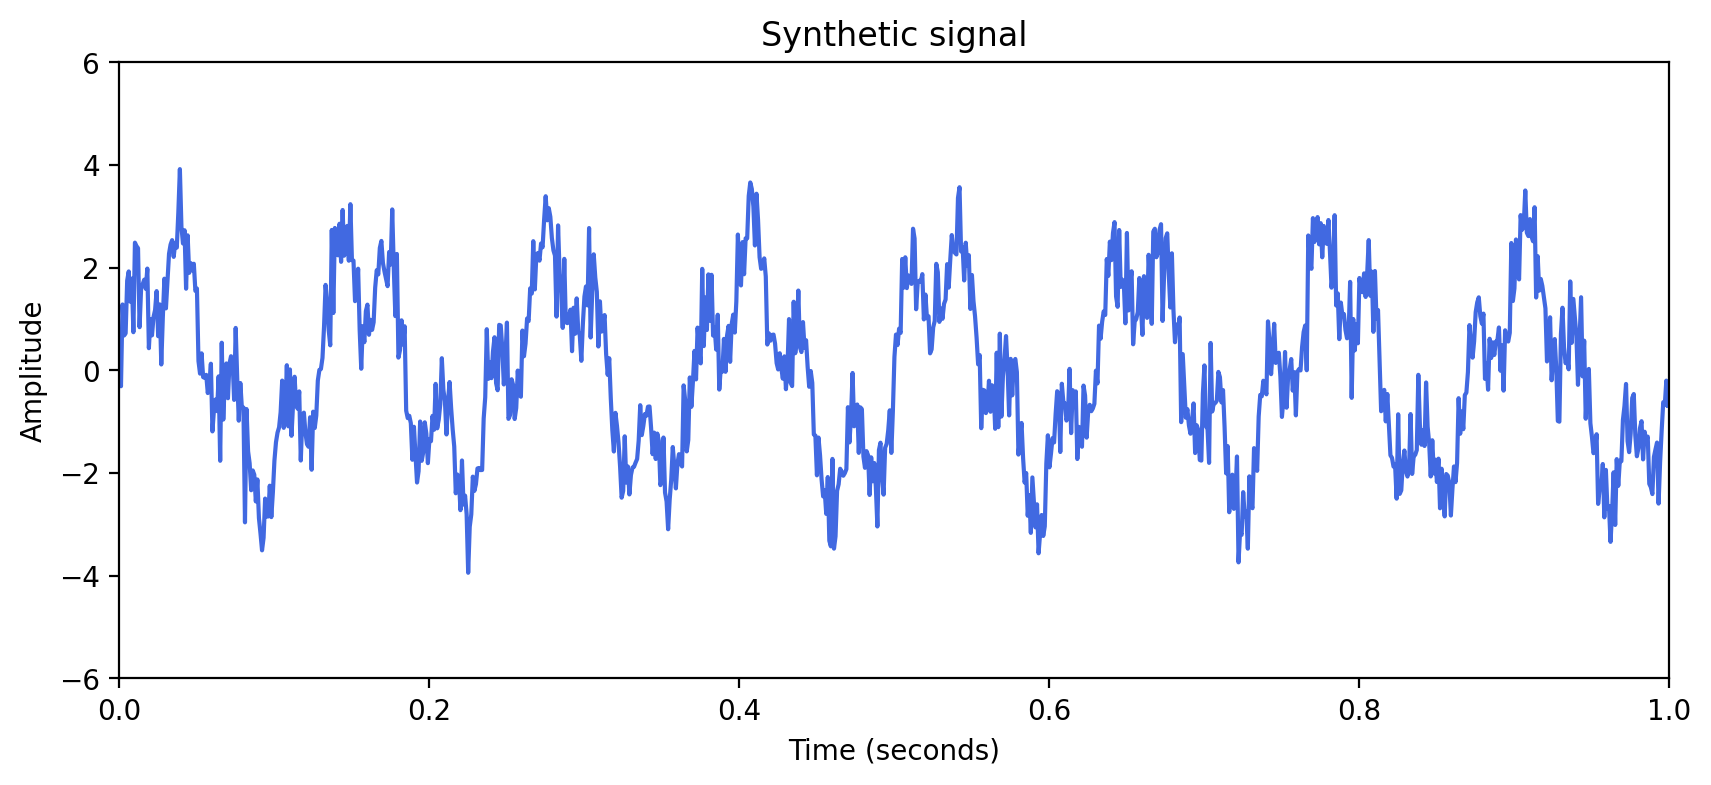

In [4]:
# @title

# @markdown Execute this cell to visualize the data

# @markdown The data is a sum of two sine waves with different frequencies and amplitudes, plus some noise

# Plot the signal
plt.figure(figsize=(10, 4))
plt.title('Synthetic signal')
plt.plot(t, LFP, 'royalblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([0, 1])
plt.ylim([-6, 6])
plt.show()

## Interactive Demo 1: Playing with signal parameters

Using an interactive widget, we can visualize how the manually inserted frequencies are present in the signal, how their amplitudes change and the effect of noise in the time series. This, however, is an overly simplistic representation, as the real signals can be decomposed into indefinite (limited by the sampling rate) frequency components.

While decoupling signal from noise in this example is as simple as moving a slider, in the real world it is one of the hardest challenges in neuroscience. 

In [5]:
# @markdown Make sure you execute this cell to enable the widget!
@widgets.interact(freq1=widgets.IntSlider(8, min=1, max=100), 
                  freq2=widgets.IntSlider(30, min=1, max=100), 
                  amp1=widgets.IntSlider(2, min=1, max=5), 
                  amp2=widgets.IntSlider(1, min=1, max=5), 
                  noise=widgets.FloatSlider(0.5, min=0, max=1.0))

def plot_data_estimate(freq1, freq2, amp1, amp2, noise):
  t = np.arange(0, 1, 1/fs)
  LFP = amp1 * np.sin(2*np.pi*freq1*t) + amp2 * np.sin(2*np.pi*freq2*t) + np.random.normal(0, noise, len(t))
  plt.figure(figsize=(10, 4))
  plt.plot(t, LFP, 'royalblue')
  plt.xlabel('Time (seconds)')
  plt.ylabel('Amplitude')
  plt.xlim([0, 1])
  plt.ylim([-6, 6])
  plt.show()


interactive(children=(IntSlider(value=8, description='freq1', min=1), IntSlider(value=30, description='freq2',…

Now we are going to introduce an artifact to our synthetic signal and see how it looks.

Artifacts can be seen as an overall increase in amplitude, the non-stationarity of a signal, a fixed power in a spurious frequency...

Artifact corrections:
    Detrending,
    Notch filter,
    Removing defective channels.

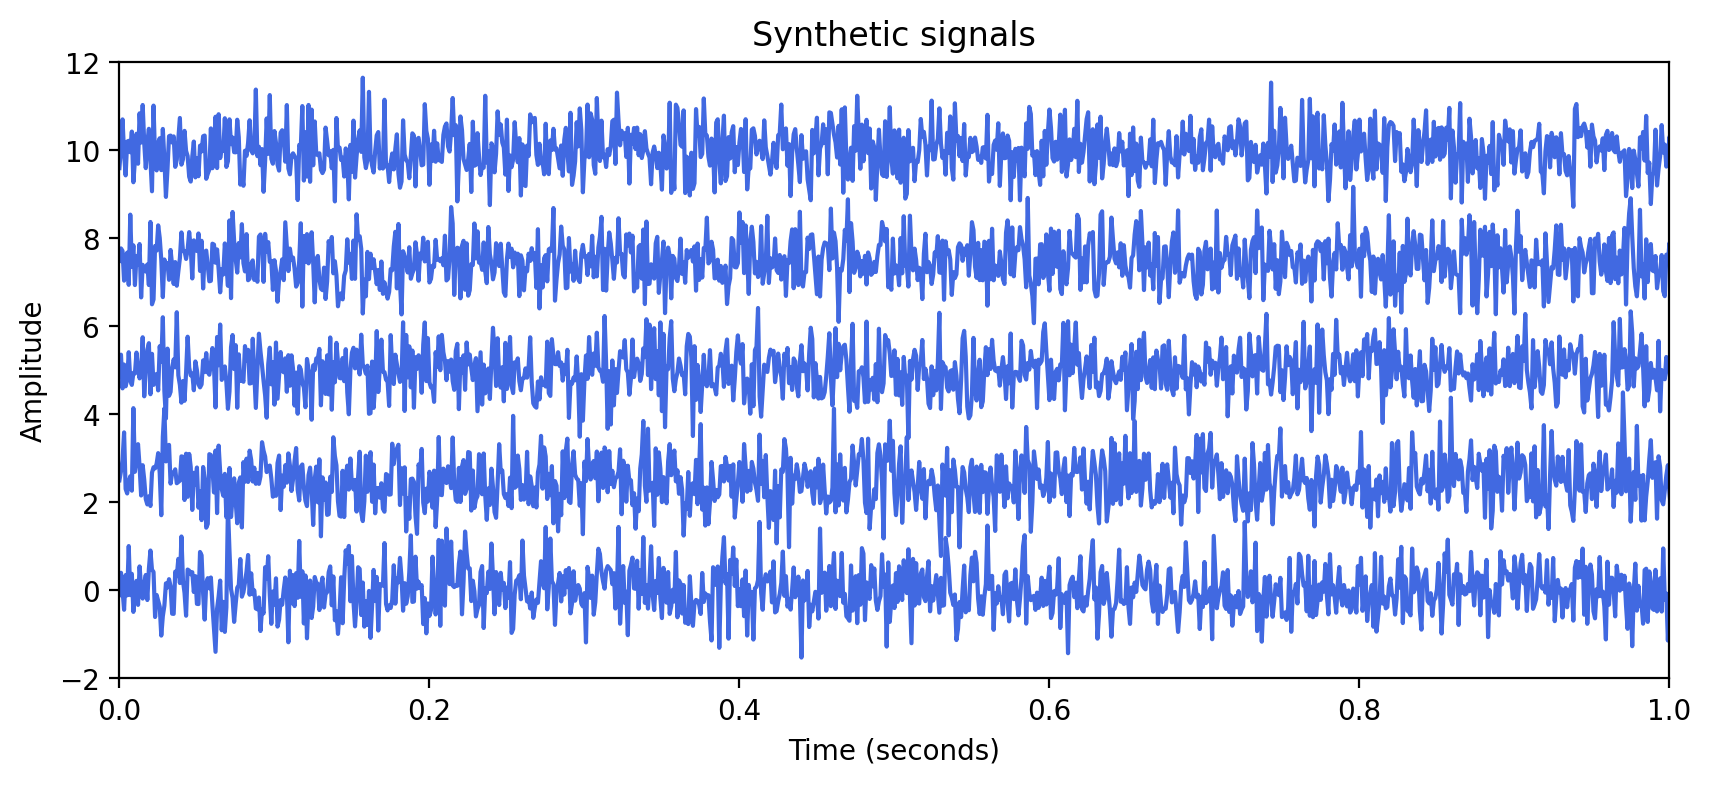

In [6]:
# Extend the signal length to 10 seconds, and create 5 signals with different parameters which should simulate different trials
t = np.arange(0, 10, 1/fs)
n_trials = 5
# Generate signals in an array
signals = np.zeros((n_trials, len(t)))

# Initialize the frequency vector
frequencies = np.arange(0.1, 100, 0.1)
# Initialize the amplitude vector (for simplicity, we will assume that the amplitudes are the inverse of the frequencies)
amplitudes = 1 / frequencies

for i in range(5):
  # assign a random amplitude between 1 and 5
  amp = amplitudes[np.random.randint(0, len(frequencies))]
  # assign a random frequency between 1 and 100
  freq = frequencies[np.random.randint(0, len(frequencies))]
  # generate signal
  signals[i, :] = (amp * np.sin(2*np.pi*freq*t) + amp * np.sin(2*np.pi*freq*t) + np.random.normal(0, 0.5, len(t))) + 2.5*i  # add noise and a constant value to separate signals
  
# Plot the signals without overlaying them
plt.figure(figsize=(10, 4))
plt.title('Synthetic signals')
plt.plot(t, signals.T, 'royalblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([0, 1])
plt.ylim([-2, 12])  # Adjust y-axis limit to accommodate the constant values
plt.show()


In [7]:
# Adding artifacts to the data

# Increase the amplitude of the third signal from 2.5s to 4.5s
signals[2, int(2.5*fs):int(4.5*fs)] = signals[2, int(2.5*fs):int(4.5*fs)] + 4

# Create a trend (linear increase) in signal 4 from 7s to 10s
signals[3, int(7*fs):int(9*fs)] = signals[3, int(7*fs):int(9*fs)] + np.linspace(0, 5, int(2*fs))

# Increase the power of 60Hz in all signals from 5.5s to 5.9s
signals[:, int(5.5*fs):int(5.9*fs)] += 0.5*np.sin(2*np.pi*60*t[int(5.5*fs):int(5.9*fs)])


In [8]:
# Create a widget to visualize the data with artifacts second by second
@widgets.interact(t=widgets.IntSlider(0, min=0, max=9))
def plot_data_artifacts(t):
  plt.figure(figsize=(10, 4))
  
  # Define the time range for one second
  time_range = np.arange(t, t+1, 1/fs)
  
  # Compute the min and max values within the current time range
  min_value = np.min(signals[:, int(t*fs):int((t+1)*fs)])
  max_value = np.max(signals[:, int(t*fs):int((t+1)*fs)])
  
  # Plot each signal in the time range
  for i in range(signals.shape[0]):
    plt.plot(time_range, signals[i, int(t*fs):int((t+1)*fs)])
  
  plt.xlabel('Time (seconds)')
  plt.ylabel('Amplitude')
  plt.xlim([t, t+1])
  plt.ylim([min_value-1, max_value+1])
  plt.show()

interactive(children=(IntSlider(value=0, description='t', max=9), Output()), _dom_classes=('widget-interact',)…

In [9]:
# Detrending the signals
import scipy.signal as signal

# Initialize the filtered signals array
filtered_signals = np.zeros(signals.shape)

# Apply the detrending function to each signal
for i in range(signals.shape[0]):
  filtered_signals[i, :] = signal.detrend(signals[i, :])

In [10]:
# Applying a notch filter to remove line (60Hz) noise

# Define the notch filter function
def notch_filter(data, fs, freq=60, Q=30):
    w0 = freq/(fs/2)
    b, a = signal.iirnotch(w0, Q)
    filtered_data = signal.filtfilt(b, a, data)
    
    return filtered_data

# Apply the notch filter to each signal
for i in range(signals.shape[0]):
    filtered_signals[i, :] = notch_filter(filtered_signals[i, :], fs)

### Loading real data from .mat files

In [11]:
# @markdown Execute this cell to loop over theta_hats, compute MSE, and plot results
from scipy.io import loadmat
# Load the data from the .mat file
probe_data = loadmat('LFPprobe.mat')
GC_data = loadmat('GC_LFPs.mat')

#### Inspecting the data

In [12]:
# Explore the data
print(probe_data.keys())
print(GC_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'LFPprobe', 'srate'])
dict_keys(['__header__', '__version__', '__globals__', 'LFP'])


In [13]:
probe_fs = probe_data['srate'].squeeze()
probe_LFP = probe_data['LFPprobe']
GC_LFP = GC_data['LFP']

print(f"The sampling rate of the probe data is {fs} Hz")
print(f"The shape of the probe data is {probe_LFP.shape}")
print(f"The shape of the GC data is {GC_LFP.shape}")

The sampling rate of the probe data is 1000 Hz
The shape of the probe data is (16, 375038)
The shape of the GC data is (144, 3500)


---
# Section 2: Transforming a time series into the frequency domain

*Estimated timing to here from start of tutorial: 20 min*

In this section, we will explore the transformation of temporal LFP signals into the frequency domain. Understanding the frequency composition of neural signals is crucial for uncovering patterns and extracting meaningful information from the data.

Procedure:

**Signal Transformation:**

Utilize Fourier transforms to convert temporal signals into the frequency domain.

**Power Spectral Density (PSD):**
Calculate and visualize the Power Spectral Density to understand the distribution of signal power across different frequencies.

**Interpretation:**
Gain insights into the frequency components that dominate the LFP signals.

### Computing the PSD using Welch's method

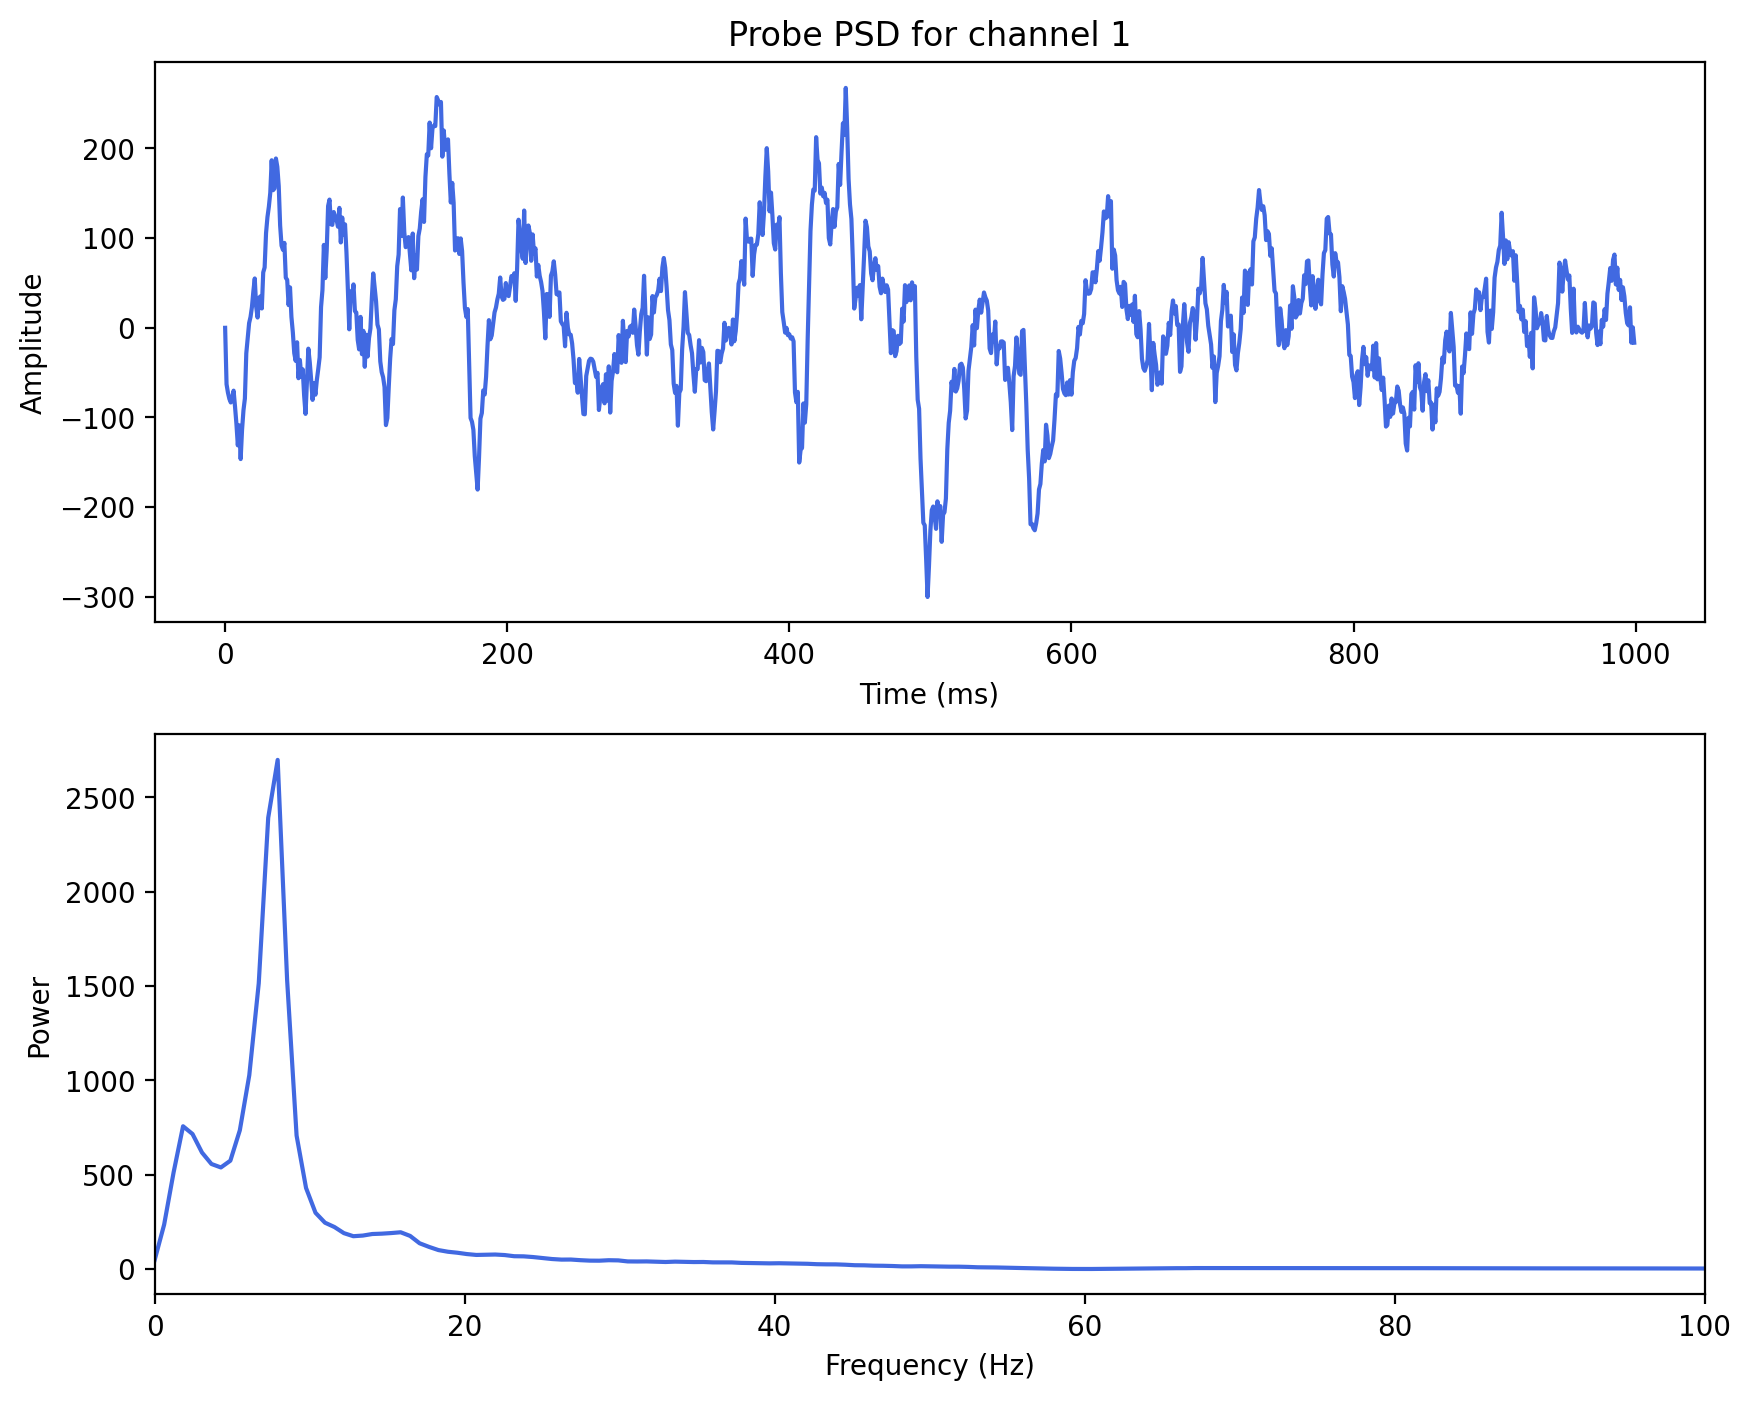

In [14]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title('Probe PSD for channel 1')
plt.plot(probe_LFP[0, 0:1000], 'royalblue')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
probe_freqs, probe_psd = signal.welch(probe_LFP[0, :], fs=probe_fs, nperseg=1024)
plt.plot(probe_freqs, probe_psd, color='royalblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim([0, 100])
plt.show()

#

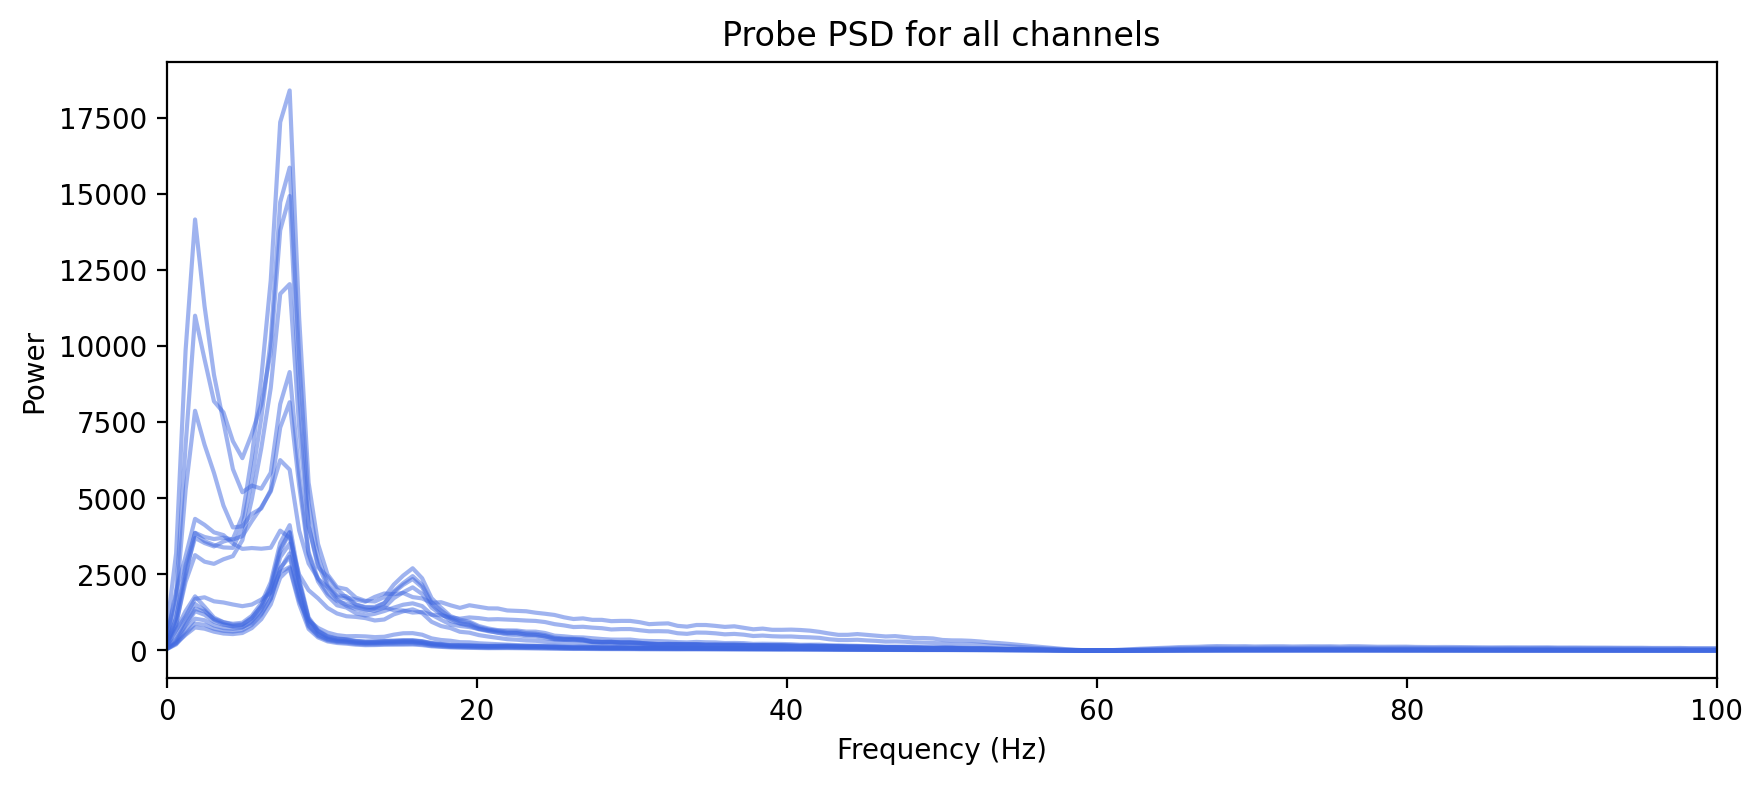

In [15]:
probe_freqs, probe_psd = signal.welch(probe_LFP, fs=probe_fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.title('Probe PSD for all channels')
plt.plot(probe_freqs, probe_psd.T, color='royalblue', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim([0, 100])
plt.show()

### The PSD usually varies with time

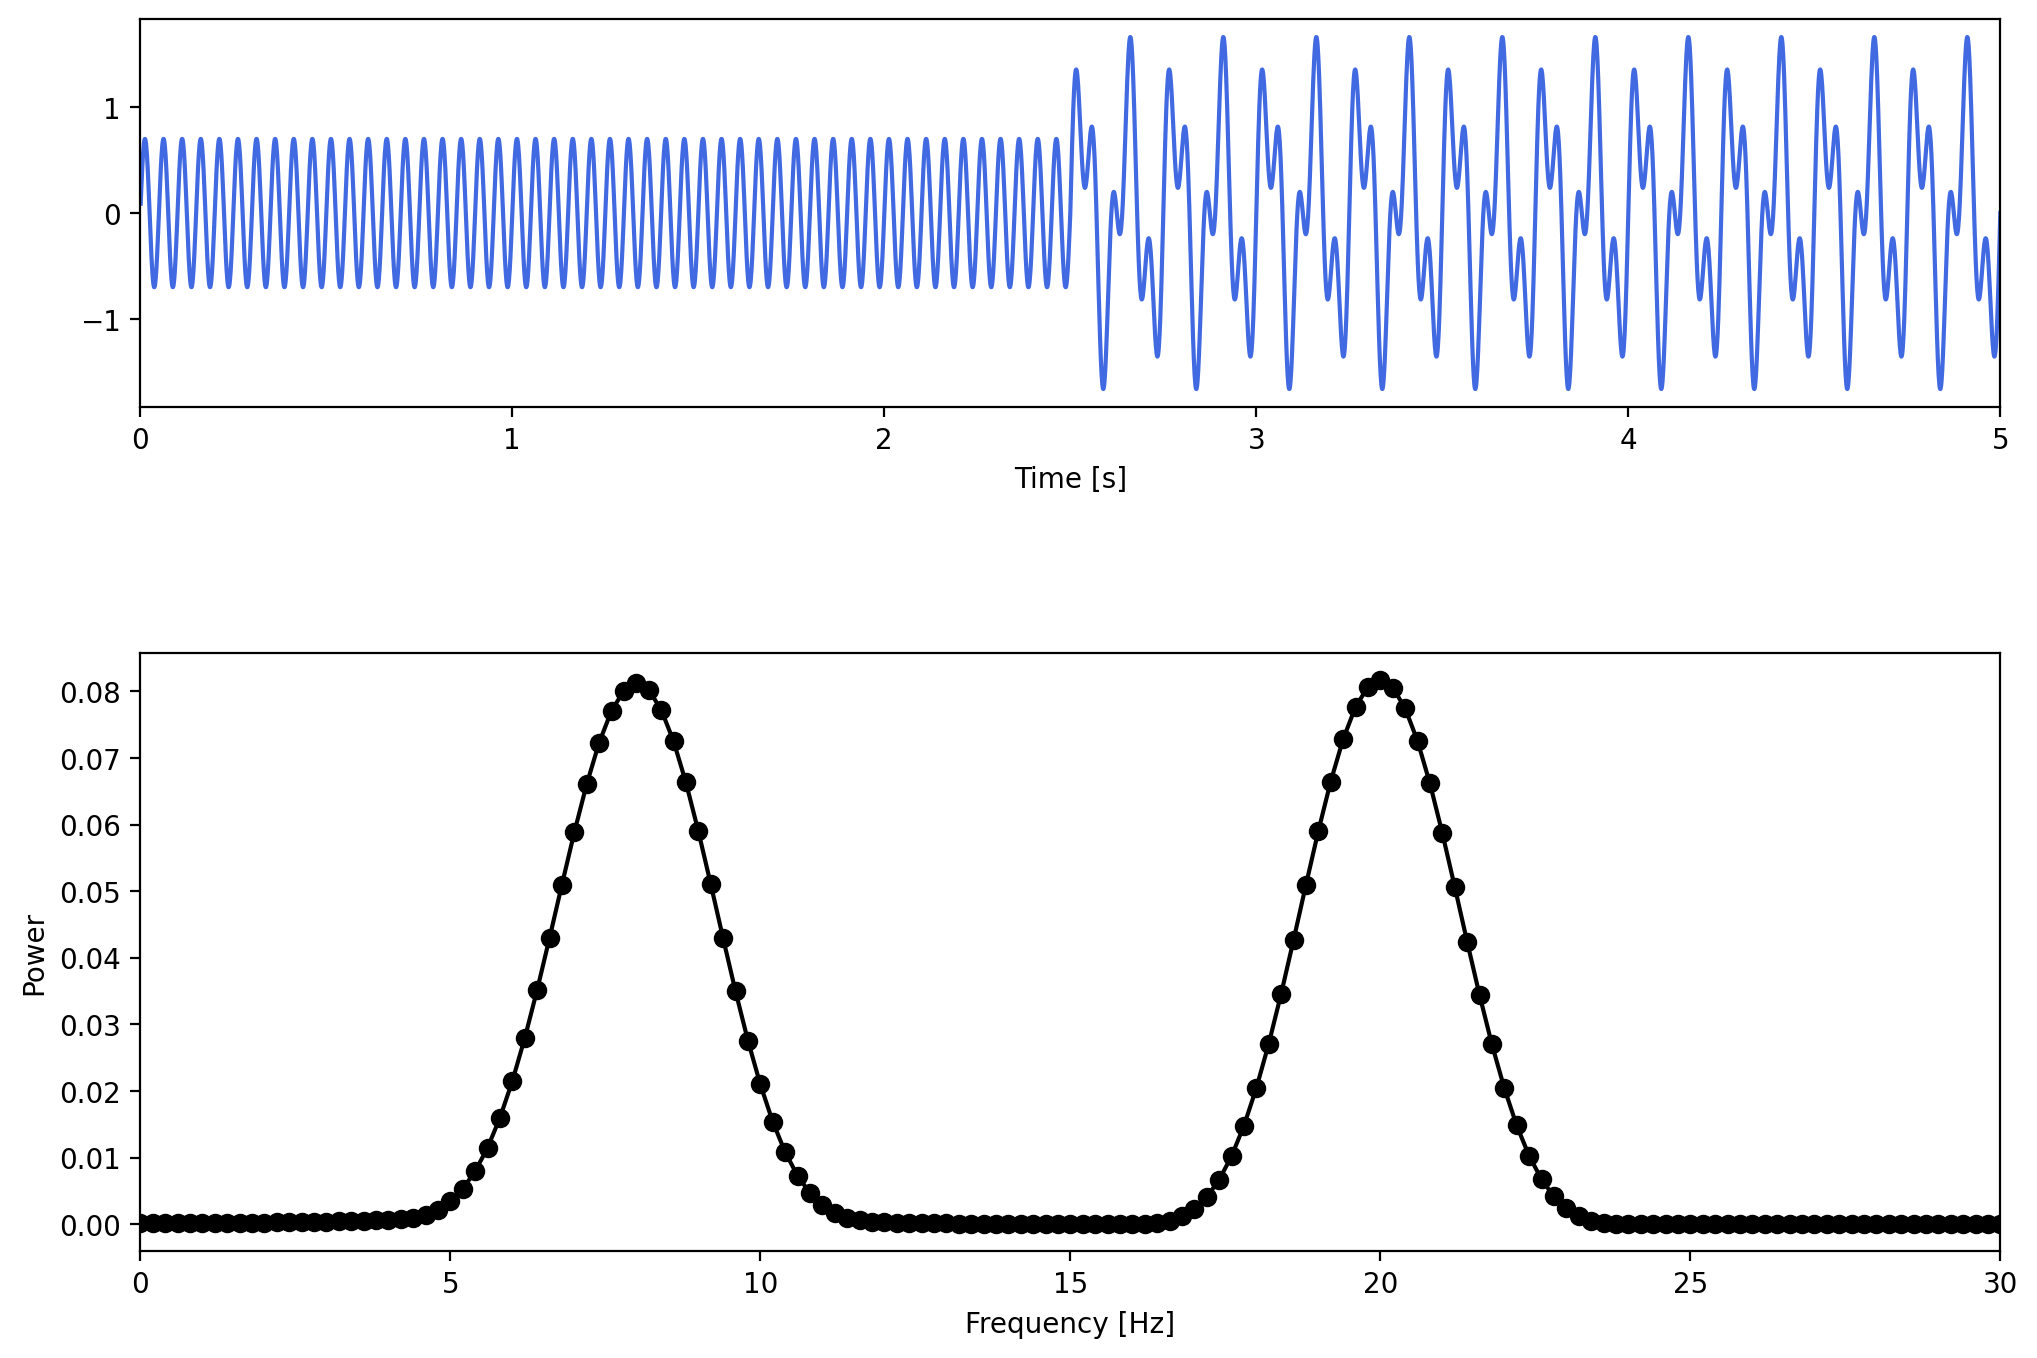

In [16]:
# Power spectral density of an artificial signal

fs = 1000.
dt = 1./fs
t = np.arange(dt,5.00001,dt)

LFP = np.sin(2*np.pi*8*t)
LFP[:2500] = 0
LFP = LFP + 0.7*np.sin(2*np.pi*20*t)

plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=2)
ax1.plot(t,LFP, color='royalblue')
ax1.set_xlabel('Time [s]')
ax1.set_xlim([0,5])

win = 0.5*fs
overlap = 0.5*win
nfft = 5000

F,Pxx = signal.welch(LFP,fs,nperseg=win,noverlap=overlap,nfft=nfft)

ax2 = plt.subplot2grid((6,1),(3,0),rowspan=3)
ax2.plot(F,Pxx,'ko-')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Power')
ax2.set_xlim([0,30])
plt.show()


---
# Section 3: Time-Frequency Analyses

*Estimated timing to here from start of tutorial: 30 min*

This section focuses on computing spectrograms, revealing the time-frequency profile of spectral power in LFP data. Spectrograms provide a dynamic view of neural activity, allowing us to uncover patterns that evolve over time.

Procedure:

**Spectrogram Calculation:**
Utilize time-frequency analysis techniques to compute the spectrogram of LFP signals.

**Visualization:**
Create visualizations that represent the time-dependent changes in spectral power.

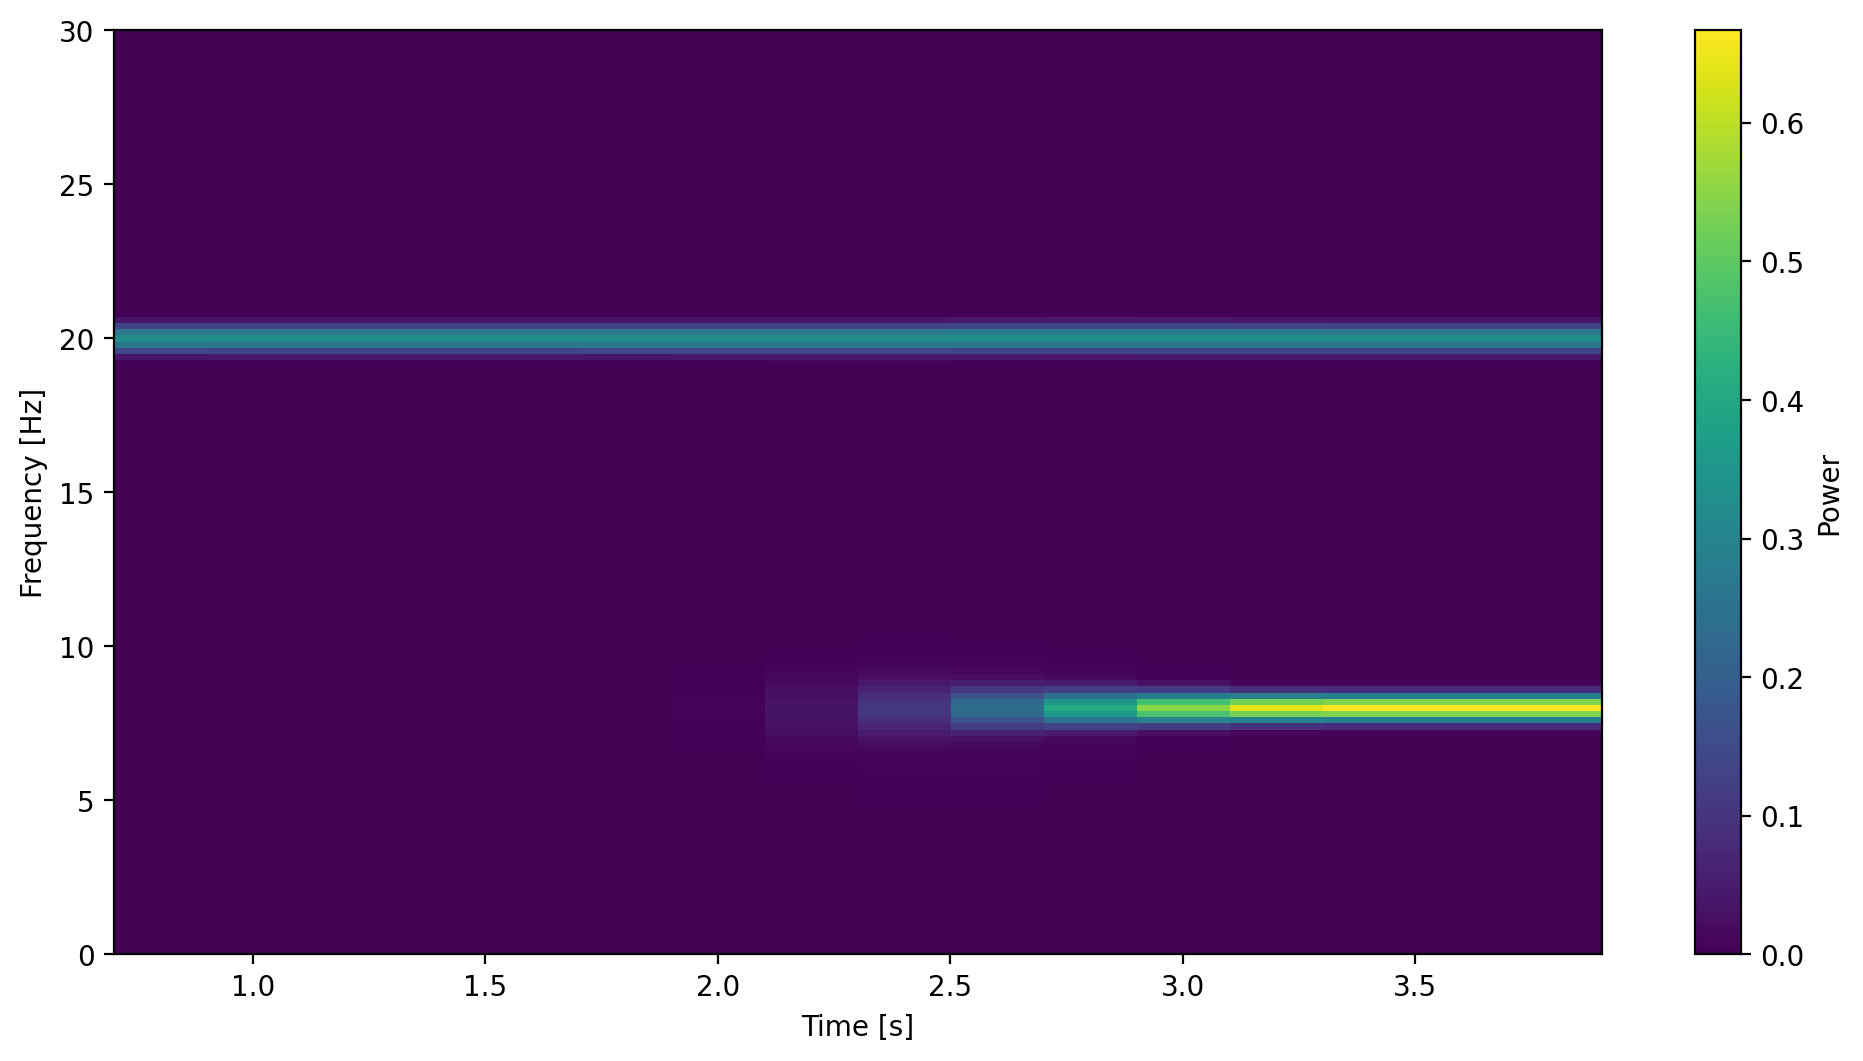

In [17]:
windowlen = int(2.*fs)      # window length
stepsize  = int(0.1*windowlen) # percentage of overlapping
Nwindows  = int((len(LFP)-windowlen)/stepsize+1)

T = np.empty(Nwindows)
TFD = np.empty((Nwindows,round(len(t)/2+1)))
for nwin in range(Nwindows):
    winsample = np.arange(windowlen) + (nwin-1)*stepsize
    F,Pxx = signal.welch(LFP[winsample],fs=fs,nperseg=windowlen,nfft=nfft)
    T[nwin] = t[int(winsample[int(windowlen/2)])]
    TFD[nwin,:] = Pxx 

plt.figure(figsize=(12,6))
plt.pcolormesh(T,F,TFD.T)
plt.ylim([0,30])
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power');

### Visualizing the frequency power changes through time

In [18]:
# @markdown Make sure you execute this cell to enable the widget!
@widgets.interact(time=widgets.IntSlider(0, min=0, max=TFD.shape[0]-1, step=1))
def update_plot(time):
    plt.figure(figsize=(10,5))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')
    plt.plot(F,TFD[int(time),:])
    plt.xlim([0,30])
    plt.ylim([0,1])
    plt.title('Time = '+str(T[time])+' s')
    plt.show()



interactive(children=(IntSlider(value=0, description='time', max=15), Output()), _dom_classes=('widget-interac…

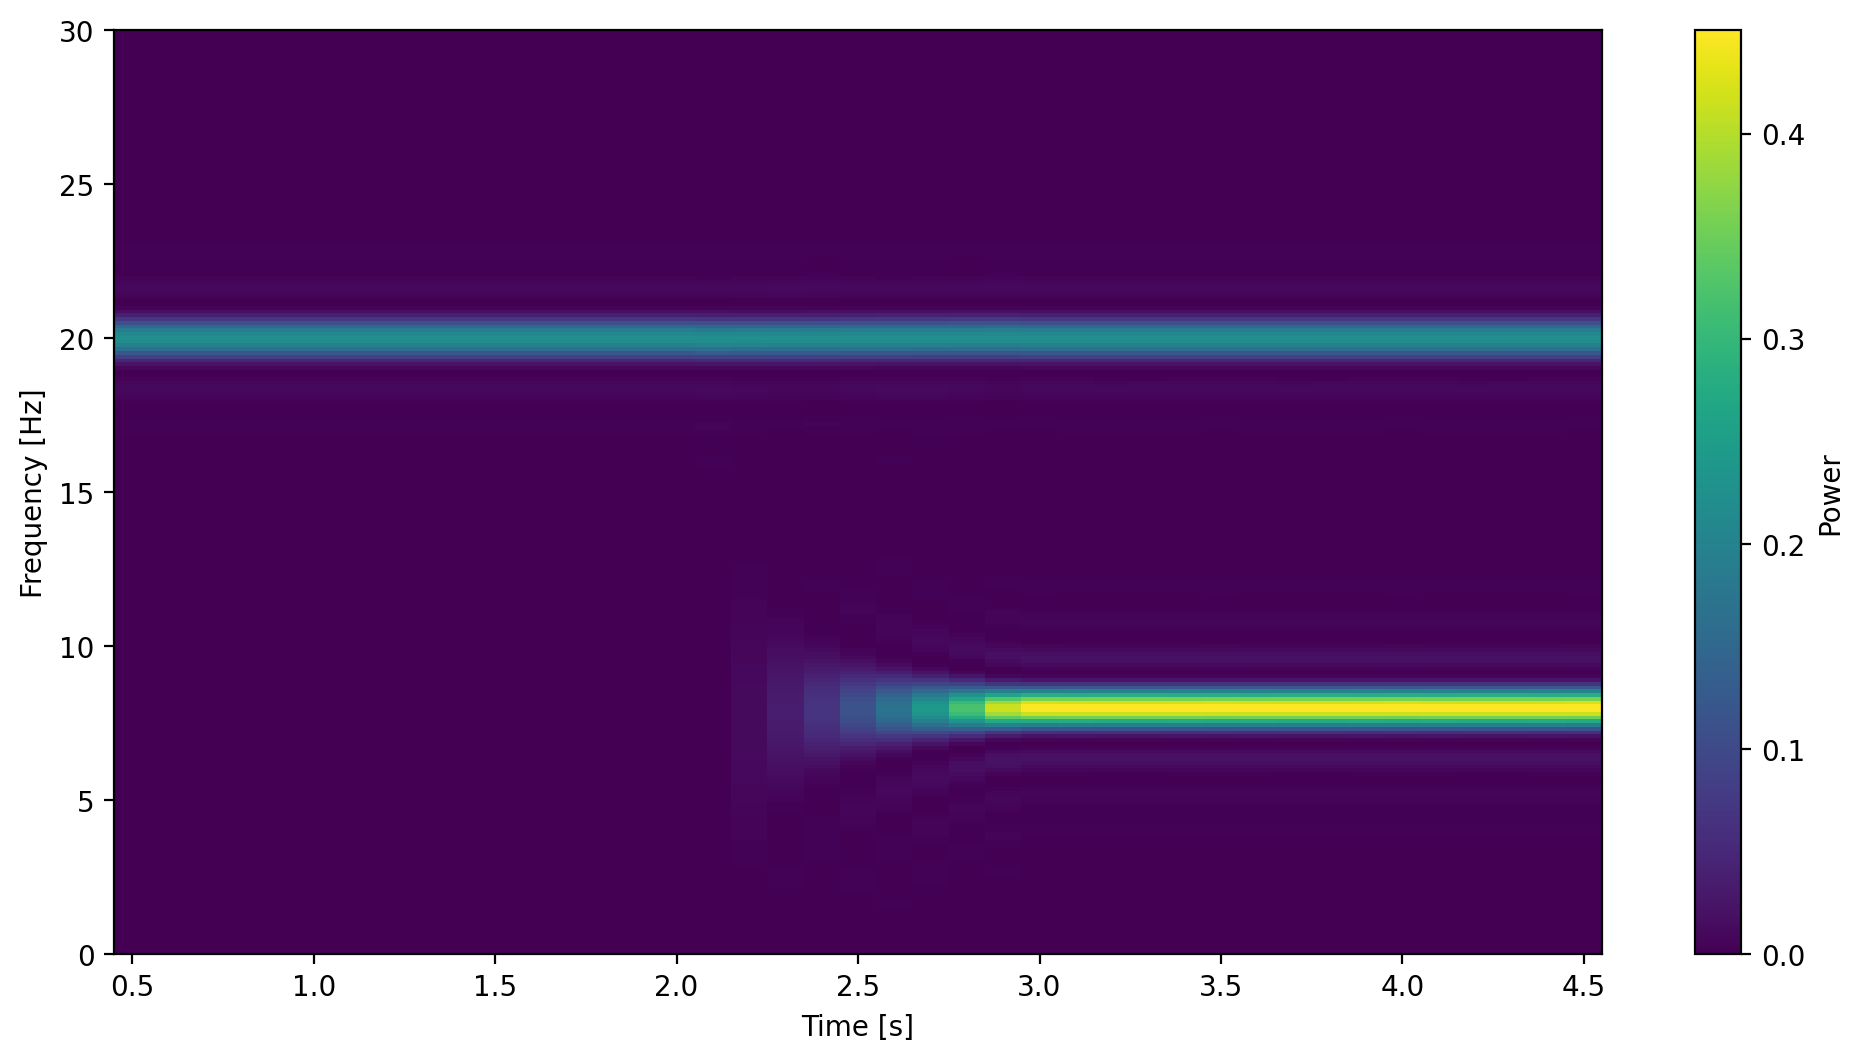

In [151]:
# Using the spectrogram function

window_length = 1*fs
overlap = 0.9*window_length
nfft = 2**13

F,T,Sxx = signal.spectrogram(LFP,fs,nperseg=int(window_length),noverlap=overlap,nfft=nfft)

plt.figure(figsize=(12,6))
plt.pcolormesh(T,F,Sxx)
plt.ylim([0,30])
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power');

---
# Section 4: Computing Phase Coherence

---
# Section 5: Calculating the Modulation Index between different frequencies

---
# Summary



**Key point**: 

**Note**: 

---
# Notation

\begin{align}
x_{i} &\quad \text{input, independent variable}\\
y_{i} &\quad \text{measurement, dependent variable}\\
\mathbf{x} &\quad \text{vector of input values}\\
\mathbf{y} &\quad \text{vector of measurements}\\
\hat{y}_{i} &\quad \text{estimate of dependent variable}\\
\epsilon_{i} &\quad \text{measurement error}\\
\theta &\quad \text{slope parameter}\\
\hat{\theta} &\quad \text{estimated slope parameter}\\
\hat{\theta}_\text{MSE} &\quad \text{slope parameter estimated via the mean squared error}\\
\textrm{MSE} &\quad \text{mean squared error}\\
\end{align}

---
# Supplementary Materials

## Databases:


This is known as solving the *normal equations*. For different ways of obtaining the solution, see the notes on [Least Squares Optimization](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf) by Eero Simoncelli.


## Resources from the open-source community:


## Learning materials: